In [1]:
import numpy as np
import matplotlib.pyplot as plt

from large_gcs.geometry.polyhedron import Polyhedron
from large_gcs.geometry.ellipsoid import Ellipsoid
from large_gcs.geometry.point import Point
from large_gcs.graph.graph import Graph, DefaultGraphCostsConstraints, Edge
from large_gcs.graph.cost_factory import (
    create_l2norm_edge_cost,
    create_l2norm_squared_edge_cost,
    create_l2norm_vertex_cost,
)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-01


100%|██████████| 9/9 [00:00<00:00, 14201.93it/s]
INFO:drake:Solved GCS shortest path using Gurobi with convex_relaxation=false and preprocessing=false and no rounding.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


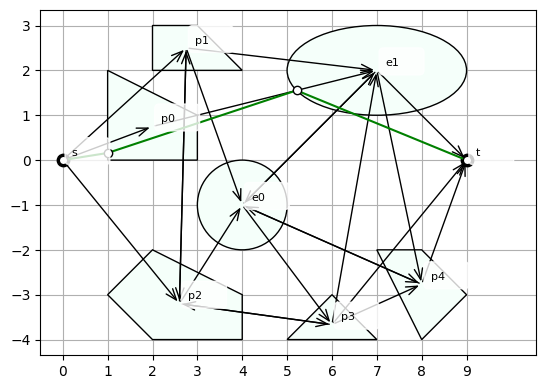

In [2]:
dim = 2
# Convex sets
points = (
    Point((0, 0)),
    Point((9, 0)),
)

polyhedra = (
    Polyhedron.from_vertices(([1, 0], [1, 2], [3, 1], [3, 0])),
    Polyhedron.from_vertices(([4, 2], [3, 3], [2, 2], [2, 3])),
    Polyhedron.from_vertices(([2, -2], [1, -3], [2, -4], [4, -4], [4, -3])),
    Polyhedron.from_vertices(([5, -4], [7, -4], [6, -3])),
    Polyhedron.from_vertices(([7, -2], [8, -2], [9, -3], [8, -4])),
)
ellipsoids = (
    Ellipsoid((4, -1), ([1, 0], [0, 1])),
    Ellipsoid((7, 2), ([0.5, 0], [0, 1])),
)

sets = points + polyhedra + ellipsoids

# Vertex names
vertex_names = ["s", "t"]
vertex_names += [f"p{i}" for i in range(len(polyhedra))]
vertex_names += [f"e{i}" for i in range(len(ellipsoids))]

# Edge costs
edge_cost = create_l2norm_edge_cost(dim)
vertex_cost = create_l2norm_vertex_cost(dim)
# edge_cost = create_l2norm_squared_edge_cost(dim)
default_costs_constraints = DefaultGraphCostsConstraints(
    edge_costs=[edge_cost],
    vertex_costs=[vertex_cost],
)
# Add convex sets to graph
G = Graph(default_costs_constraints)
G.add_vertices_from_sets(sets, names=vertex_names)
G.set_source("s")
G.set_target("t")

# Edges
edges = {
    "s": ("p0", "p1", "p2"),
    "p0": ("e1",),
    "p1": ("p2", "e0", "e1"),
    "p2": ("p1", "p3", "e0"),
    "p3": ("t", "p2", "p4", "e1"),
    "p4": ("t", "e0"),
    "e0": ("p3", "p4", "e1"),
    "e1": ("t", "p4", "e0"),
}
for u, vs in edges.items():
    for v in vs:
        G.add_edge(Edge(u, v))

sol = G.solve_shortest_path()
# draw convex sets and edges
plt.figure()
G.plot_sets()
G.plot_edges()
G.plot_set_labels()
G.plot_path(sol.ambient_path)
plt.xticks(range(10))
plt.grid()

plt.show()

In [3]:
for v in sol.vertex_path:
    vertex_cost = G.vertices[v].gcs_vertex.GetSolutionCost(sol.result)
    print(f"{v}: {vertex_cost}")

s: 0.0
p0: 1.012571273682441
e1: 5.437140474780631
t: 9.0


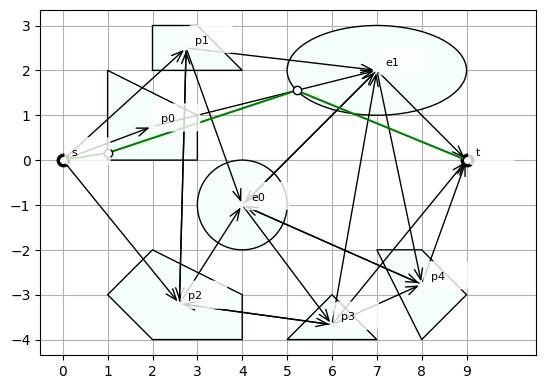

In [4]:
active_edges = [("s", "p0"), ("p0", "e1"), ("e1", "t")]
sol = G.solve_convex_restriction(active_edges)

# draw convex sets and edges
plt.figure()
G.plot_sets()
G.plot_edges()
G.plot_set_labels()
G.plot_path(sol.ambient_path)
plt.xticks(range(10))
plt.grid()

plt.show()

In [5]:
for v in sol.vertex_path:
    vertex_cost = G.vertices[v].gcs_vertex.GetSolutionCost(sol.result)
    print(f"{v}: {vertex_cost}")

# for e in active_edges:
#     try:
#         edge_v = G.edges[e].gcs_edge.v()
#         vertex_cost = edge_v.GetSolutionCost(sol.result)
#         print(f"{v}: {vertex_cost}")
#         edge_cost = G.edges[e].gcs_edge.GetSolutionCost(sol.result)
#         print(f"{e}: {edge_cost}")
#     except:
#         print("failed")

ValueError: GetVariableValue: v_ell0 is not captured by the variable_index map.

In [6]:
sol.result.get_decision_variable_index()

AttributeError: 'pydrake.solvers.MathematicalProgramResult' object has no attribute 'get_decision_variable_index'